In [ ]:
! gdown 1X1jZgrRaVH-h0xX3k8cSzT0kumIVlmwx #sarc_emojis_1000.csv
! gdown 1--LLxkODAryG3TgUHrcggfrYoXnr9UFe #not_sarc_emojis_1000.csv

Downloading...
From: https://drive.google.com/uc?id=1X1jZgrRaVH-h0xX3k8cSzT0kumIVlmwx
To: /content/sarc_emojis_1000.csv
100% 1.60M/1.60M [00:00<00:00, 22.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--LLxkODAryG3TgUHrcggfrYoXnr9UFe
To: /content/not_sarc_emojis_1000.csv
100% 1.68M/1.68M [00:00<00:00, 66.8MB/s]


In [ ]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 5.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import torch

# Load the data
sarcastic_df = pd.read_csv('sarc_emojis_1000.csv')
nonsarcastic_df = pd.read_csv('not_sarc_emojis_1000.csv')

# Combine the data into a single DataFrame
sarcastic_df['sarcastic'] = 1
nonsarcastic_df['sarcastic'] = 0
df = pd.concat([sarcastic_df, nonsarcastic_df])

# Encode the labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Split the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the data
def tokenize_function(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=64)

train_encodings = train_df['text'].apply(tokenize_function).tolist()
test_encodings = test_df['text'].apply(tokenize_function).tolist()

# Create torch datasets
class EmojiDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val) for key, val in self.encodings[idx].items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_labels = train_df['label'].tolist()
test_labels = test_df['label'].tolist()

train_dataset = EmojiDataset(train_encodings, train_labels)
test_dataset = EmojiDataset(test_encodings, test_labels)

# Load the DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    fp16=True,                      # Use mixed precision
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer
)

# Train the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,2.902500
1000,2.736000


TypeError: argmax(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

## הערכת ביצועי המודל - כללי

In [ ]:
# Evaluate the model
predictions, labels, _ = trainer.predict(test_dataset)

# Convert predictions to tensor
predictions = torch.tensor(predictions)

# Calculate predictions
preds = torch.argmax(predictions, axis=1)

# Calculate overall metrics
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds, average='macro')
recall = recall_score(labels, preds, average='macro')
f1 = f1_score(labels, preds, average='macro')

print(f'Overall Accuracy: {accuracy}')
print(f'Overall Precision: {precision}')
print(f'Overall Recall: {recall}')
print(f'Overall F1 Score: {f1}')


Overall Accuracy: 0.17625
Overall Precision: 0.14843661556514656
Overall Recall: 0.17625
Overall F1 Score: 0.14814203505504991


## שמירת תוצאות המודל עבור קבוצת הבדיקה

In [ ]:
# Create DataFrame
results_df = pd.DataFrame({
    'text': test_df['text'],  # Assuming 'text' is the column name for text in your DataFrame
    'original_label': label_encoder.inverse_transform(test_df['label']),  # Assuming 'labels' is the variable containing original labels
    'predicted_label': label_encoder.inverse_transform(preds),  # Assuming 'preds' is the variable containing predicted labels
    'sarcastic': test_df['sarcastic'],  # Assuming 'sarcastic' is the column name for sarcastic in your DataFrame
})

# Add column for successful prediction
results_df['prediction_success'] = results_df['original_label'] == results_df['predicted_label']

# Save results to CSV
results_df.to_csv('emoji_analysis_results.csv', index=False)

print(results_df)


                                                    text original_label  \
14985               thanks for including me, lol u rock               😜   
2470                             thank you too!!! enjoy               👍   
1309   too many choices. decisions. decisions. decisi...              😂   
6106             thank you. i really like using pastels               😊   
12446                        i just cant with his mouth               😐   
...                                                  ...            ...   
2862               most productive geo class of my life               👍   
1358   me while scrolling social media when i found a...              😂   
13184                   tell me how you really feel ...               😳   
10957        hahaha aweeeee all he wanted was a fweeend               😔   
8887                       ohhhh thats what try it means              😏   

      predicted_label  sarcastic  prediction_success  
14985               ☺          1            

## confusion matrix כללי

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128076 (\N{OK HAND SIGN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128079 (\N{CLAPPING HANDS SIGN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 129300 (\N{THINKING FACE}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128076 (\N{OK HAND SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dis

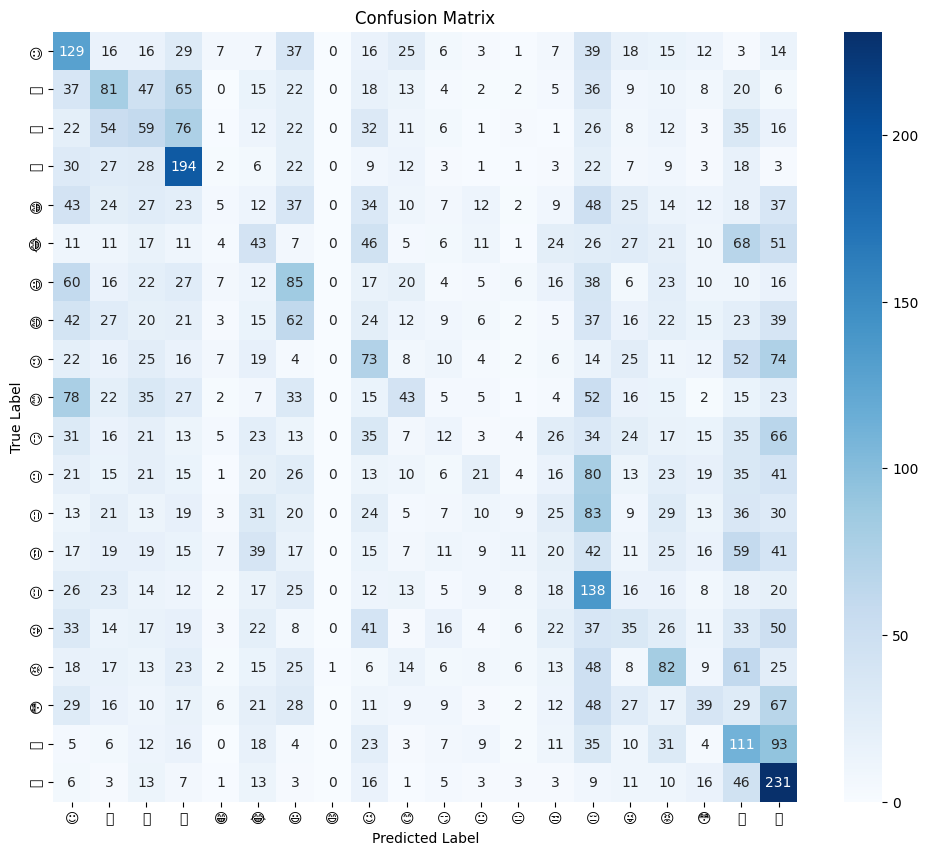

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Read the results CSV file
results_df = pd.read_csv('emoji_analysis_results.csv')

# Ensure the original_label and predicted_label are of string type
results_df['original_label'] = results_df['original_label'].astype(str)
results_df['predicted_label'] = results_df['predicted_label'].astype(str)

# Create confusion matrix
conf_matrix = confusion_matrix(results_df['original_label'], results_df['predicted_label'], labels=label_encoder.classes_)

# Convert the labels back to textual emojis for the heatmap
labels = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Save confusion matrix as image
plt.savefig('confusion_matrix.png')


## הערכת ביצועי המודל עבור כל אימוג'י

### מציאת FP FN  לכל האימוג'ים

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Map numeric labels back to textual emojis
results_df['original_label'] = label_encoder.inverse_transform(results_df['original_label'])
results_df['predicted_label'] = label_encoder.inverse_transform(results_df['predicted_label'])

# Add column for successful prediction
results_df['prediction_success'] = results_df['original_label'] == results_df['predicted_label']

# Save results to CSV
results_df.to_csv('emoji_analysis_results.csv', index=False)

# Find False Positives and False Negatives for each emoji
false_positives = []
false_negatives = []

emojis = label_encoder.classes_

for emoji in emojis:
    # False Positives: predicted as emoji but original label is different
    fp_examples = results_df[(results_df['predicted_label'] == emoji) & (results_df['original_label'] != emoji)]
    false_positives.extend(fp_examples.head(3).to_dict('records'))  # Get up to 3 examples

    # False Negatives: original label is emoji but predicted as different
    fn_examples = results_df[(results_df['original_label'] == emoji) & (results_df['predicted_label'] != emoji)]
    false_negatives.extend(fn_examples.head(3).to_dict('records'))  # Get up to 3 examples

# Convert lists to DataFrames
false_positives_df = pd.DataFrame(false_positives)
false_negatives_df = pd.DataFrame(false_negatives)

# Save False Positives and False Negatives to CSV
false_positives_df.to_csv('false_positives.csv', index=False)
false_negatives_df.to_csv('false_negatives.csv', index=False)

print("False Positives:\n", false_positives_df)
print("False Negatives:\n", false_negatives_df)


### ניתוח FP FN לכל אימוגי

In [ ]:
import pandas as pd

# Read False Positives and False Negatives CSV files
false_positives_df = pd.read_csv('false_positives.csv')
false_negatives_df = pd.read_csv('false_negatives.csv')

# Print False Positives examples
print("False Positives Examples:")
for emoji, group in false_positives_df.groupby('original_label'):
    print(f"Emoji: {emoji}")
    for idx, row in group.iterrows():
        print(f"Text: {row['text']}, Predicted: {row['predicted_label']}, Original: {row['original_label']}")
    print()

# Print False Negatives examples
print("False Negatives Examples:")
for emoji, group in false_negatives_df.groupby('original_label'):
    print(f"Emoji: {emoji}")
    for idx, row in group.iterrows():
        print(f"Text: {row['text']}, Predicted: {row['predicted_label']}, Original: {row['original_label']}")
    print()


False Positives Examples:
Emoji: ☺
Text: alright, this should be fun to see. , Predicted: 😃, Original: ☺
Text: i have participated in following the guidelines and rules of this airdrop, i hope that many people will be lucky to get a prize from this airdrop , Predicted: 😉, Original: ☺
Text: follow me back thanks, Predicted: 😊, Original: ☺
Text: the north korean vegan trans hacker dao was granted $100m all by the community  $one, Predicted: 🙄, Original: ☺

Emoji: 👌
Text: balixrp thedustybc xrp will be more than a million in 2030, remember this tweet , Predicted: 👍, Original: 👌
Text: panget pala talaga pag di ka naka planong kasama. they only want you because of the thing you can offer that they dont have, Predicted: 😂, Original: 👌
Text: living in people's heads rent free , Predicted: 😑, Original: 👌
Text: was great in an episode of fawlty towers  very funny. think he was in an early carry on too., Predicted: 😳, Original: 👌

Emoji: 👍
Text: thank you too!!! enjoy , Predicted: ☺, Original: 👍

In [ ]:
# Define a function to save print statements to a text file
def save_print_to_file(print_func, file_path):
    import sys
    original_stdout = sys.stdout
    with open(file_path, 'w') as f:
        sys.stdout = f
        print_func()
    sys.stdout = original_stdout

# Define function to print examples from false positives and false negatives
def print_examples(false_positives_df, false_negatives_df):
    print("False Positives Examples:")
    for emoji, group in false_positives_df.groupby('original_label'):
        print(f"Emoji: {emoji}")
        for idx, row in group.iterrows():
            print(f"Text: {row['text']}, Predicted: {row['predicted_label']}, Original: {row['original_label']}")
        print()

    print("False Negatives Examples:")
    for emoji, group in false_negatives_df.groupby('original_label'):
        print(f"Emoji: {emoji}")
        for idx, row in group.iterrows():
            print(f"Text: {row['text']}, Predicted: {row['predicted_label']}, Original: {row['original_label']}")
        print()

# Save the print statements to a text file
save_print_to_file(lambda: print_examples(false_positives_df, false_negatives_df), 'examples_output.txt')


### שמירת כל שגיאות הסיווג לכל האימוגים בקובץ אחד

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Find False Positives and False Negatives for each emoji
false_positives = []
false_negatives = []

emojis = label_encoder.classes_

for emoji in emojis:
    # False Positives: predicted as emoji but original label is different
    fp_examples = results_df[(results_df['predicted_label'] == emoji) & (results_df['original_label'] != emoji)]
    false_positives.extend(fp_examples.head(3).to_dict('records'))  # Get up to 3 examples

    # False Negatives: original label is emoji but predicted as different
    fn_examples = results_df[(results_df['original_label'] == emoji) & (results_df['predicted_label'] != emoji)]
    false_negatives.extend(fn_examples.head(3).to_dict('records'))  # Get up to 3 examples

# Convert lists to DataFrames
false_positives_df = pd.DataFrame(false_positives)
false_negatives_df = pd.DataFrame(false_negatives)

# Save False Positives and False Negatives to CSV
false_positives_df.to_csv('false_positives.csv', index=False)
false_negatives_df.to_csv('false_negatives.csv', index=False)

print("False Positives:\n", false_positives_df)
print("False Negatives:\n", false_negatives_df)

# Create a combined DataFrame for False Positives and False Negatives with a new column indicating the type of error
false_positives_df['error_type'] = 'False Positive'
false_negatives_df['error_type'] = 'False Negative'

combined_errors_df = pd.concat([false_positives_df, false_negatives_df], ignore_index=True)

# Save combined errors DataFrame to CSV
combined_errors_df.to_csv('combined_errors.csv', index=False)

print("Combined Errors:\n", combined_errors_df)


False Positives:
                                                  text original_label  \
0                thanks for including me, lol u rock               😜   
1                             thank you too!!! enjoy               👍   
2   hai agraa, what did you do today? i hope it wa...              😄   
3   too many choices. decisions. decisions. decisi...              😂   
4   i have one shirt and one pair of trousers that...              😒   
5   he seems like a nice guy  good to see he's got...              😉   
6    buzzin for work tomo after 6 n a half weeks off               😐   
7   balixrp thedustybc xrp will be more than a mil...              👌   
8   nice to see matic keeping his place in the sid...              😒   
9                           manila fansign got bambam              😉   
10  weather widget is stuck on the city i was at y...              😐   
11  oh the horror!!! she positively to the lives o...              😐   
12            come on man!! you've got till no

### שמירת שגיאות סיווג של כל אימוגי בקובץ נפרד

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# קריאת הקובץ המכיל את תוצאות הסיווג
results_df = pd.read_csv('emoji_analysis_results.csv')

# ודא שהתוויות המקוריות והתוויות החזויות הן מסוג string
results_df['original_label'] = results_df['original_label'].astype(str)
results_df['predicted_label'] = results_df['predicted_label'].astype(str)

# מציאת דוגמאות של False Positives ו-False Negatives עבור כל אימוג'י
emojis = results_df['original_label'].unique()

for emoji in emojis:
    error_records = []

    # False Positives: ניבאו את האימוג'י הזה אבל בפועל היה אימוג'י אחר
    fp_examples = results_df[(results_df['predicted_label'] == emoji) & (results_df['original_label'] != emoji)]
    for index, row in fp_examples.iterrows():
        error_records.append({
            'Error Type': 'FP',
            'Text': row['text'],
            'Original Label': row['original_label'],
            'Predicted Label': row['predicted_label']
        })

    # False Negatives: בפועל היה אמור להיות האימוג'י הזה אבל ניבאו אימוג'י אחר
    fn_examples = results_df[(results_df['original_label'] == emoji) & (results_df['predicted_label'] != emoji)]
    for index, row in fn_examples.iterrows():
        error_records.append({
            'Error Type': 'FN',
            'Text': row['text'],
            'Original Label': row['original_label'],
            'Predicted Label': row['predicted_label']
        })

    # המרת הרשימה ל-DataFrame
    error_df = pd.DataFrame(error_records)

    # שמירת DataFrame לקובץ CSV
    error_df.to_csv(f'errors_analysis_{emoji}.csv', index=False, encoding='utf-8-sig')

print("Error analysis files saved for each emoji.")


### שמירת 3 שגיאות סיווג מכל סוג לכל אימוג'י

In [ ]:
# יצירת קובץ טקסט עם שלוש דוגמאות של FP ו-FN עבור כל אימוג'י
with open('emoji_errors_summary.txt', 'w', encoding='utf-8') as f:
    for emoji in emojis:
        f.write(f"Emoji: {emoji}\n")

        # False Positives: ניבאו את האימוג'י הזה אבל בפועל היה אימוג'י אחר
        fp_examples = results_df[(results_df['predicted_label'] == emoji) & (results_df['original_label'] != emoji)]
        f.write("False Positives:\n")
        for index, row in fp_examples.head(3).iterrows():
            f.write(f"Text: {row['text']}, Predicted: {row['predicted_label']}, Original: {row['original_label']}\n")

        # False Negatives: בפועל היה אמור להיות האימוג'י הזה אבל ניבאו אימוג'י אחר
        fn_examples = results_df[(results_df['original_label'] == emoji) & (results_df['predicted_label'] != emoji)]
        f.write("False Negatives:\n")
        for index, row in fn_examples.head(3).iterrows():
            f.write(f"Text: {row['text']}, Predicted: {row['predicted_label']}, Original: {row['original_label']}\n")

        f.write("\n")

print("Summary of emoji errors saved to emoji_errors_summary.txt")
